# 1. A basic Pastas model
In this notebook you will learn:
- how to create a basic time series model with pastas.
- how to solve a pastas model.
- how to visualise the results of a time series model.

#### Required knowledge
Before you start the exercise you should know:
- What a `pandas` `DataFrame` and `Series` are.
- What a `datetime` object in Python is.
- What a `dictionary` is.
- How to obtain a subset of a `Series` using a certain condition.
- How to make a basic plot with `matplotlib.pyplot`.
- How to obtain values from a `dictionary`.


### Contents
1. [Import groundwater data](#groundwater)
2. [Import meteo data](#meteo)
3. [Create a pastas model](#tsa_model)
4. [Solve the pastas model](#solve)
5. [Plot the results](#visualise)

In [2]:
# importeer de benodigde packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pastas as ps
%matplotlib inline

### 1. Import the groundwater data<a name="groundwater"></a>
In this codeblock a time series of groundwater levels is imported using the `read_csv` function of `pandas`. We use the date column as the index and parse the dates as datetime objects. The `read_csv` function returns a `DataFrame` by default. We use `squeeze=True` because `pastas` expects a `pandas` `Series` object. To check if you have the correct data type (a `pandas Series` object), you can use `type(gwdata_raw)` as shown below. 

In [3]:
# Import groundwater time series and squeeze to Series object
gwdata_raw = pd.read_csv('data/nb1/head_ex1.csv', parse_dates=True,
                         index_col='date', squeeze=True)
print(f'The data type of gwdata is: {type(gwdata_raw)}')

The data type of gwdata is: <class 'pandas.core.series.Series'>


We can visualize the timeseries using the `plot` method of a `Series` object.

''

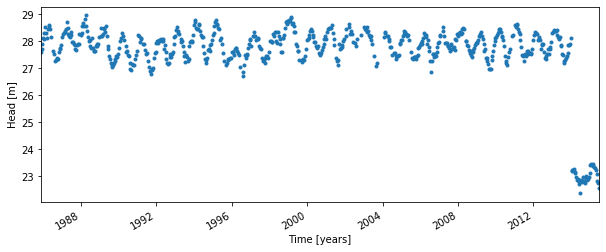

In [4]:
# visualise the observed groundwater levels
fig, ax = plt.subplots(figsize=(10, 4))
gwdata_raw.plot(style='.', ax=ax)
ax.set_ylabel('Head [m]')
ax.set_xlabel('Time [years]')
;

Before we create a pastas model it is important that we are able to visualise and manipulate the data to our needs. The exercises below will help you with this.

#### Exercise 1 <a name="ex1"></a>
The observed groundwater levels are obtained from the DinoLoket database. The code of the well is 'B58C0698'. Plot the observed groundwater levels over time and add a legend to the plot with the well code. 

<a href="#ans1">Answer Exercise 1</a>

#### Exercise 2 <a name="ex2"></a>
We will not use the observed groundwater levels before the 1st of January 2000. Plot the groundwater levels before 2000 as red dots and the data after 2000 as green dots connected by a line.

<a href="#ans2">Answer Exercise 2</a>

#### Exercise 3<a name="ex3"></a>
The groundwater levels after 2014 are clearly lower than before. After 2014 a wrong reference level has been used. A reference level is used to convert raw measurements. The reference level differs 5 meters from the correct level. Correct `gwdata_raw` for this mistake by adding 5 meter to the data after 2014. Save the corrected series as `gwdata`. Write your code in the cell below.

<a href="#ans3">Answer Exercise 3</a>

### 2. Import meteo data <a name="meteo"></a>
For the time series model we will use the groundwater data along with two meteorological datasets: the precipitation and the potential evaporation. Just like the groundwater levels we need to Squeeze them into `pandas Series` objects.

In [5]:
# Import observed precipitation series
precip_mm = pd.read_csv('data/nb1/rain_ex4.csv', parse_dates=['date'],
                        index_col='date', squeeze=True)
print('The data type of the precip series is: %s' % type(precip_mm))

# Import observed evaporation series
evap_mm = pd.read_csv('data/nb1/evap_ex4.csv', parse_dates=['date'],
                      index_col='date', squeeze=True)
print('The data type of the evap series is: %s' % type(evap_mm))

The data type of the precip series is: <class 'pandas.core.series.Series'>
The data type of the evap series is: <class 'pandas.core.series.Series'>


#### Exercise 4 <a name="ex4"></a>
The units of the precipitation (`precip_mm`) and evaporation (`evap_mm`) series are mm/day. In a timeseries model we want all series to have the same units. Convert the units of the precipitation and evaporation series to m/day. Name your new variables `evap_m` and `precip_m`.

<a href="#ans4">Answer Exercise 4</a>

#### Exercise 5 <a name="ex5"></a>
Visualize both series in two plots.

<a href="#ans5">Answer Exercise 5</a>

#### Exercise 6 <a name="ex6"></a>
The groundwater recharge can be calculated as the precipitation minus the potential evaporation. We will use the recharge in this basic time series model to explain the variance in the groundwater. Calculate and visualise the recharge, use the `precip_m` and `evap_m` from exercise 4.

<a href="#ans6">Answer Exercise 6</a>

### 3. Create a pastas model<a name="tsa_model"></a>
Now that we have the groundwater and recharge series we can start to create a time series model. With this model we can determine to what extend the groundwater is influenced by the recharge. 

We start by creating an instance of the `Model` class (named `ml` here). We use the groundwater data `gwdata` as input. Pastas will probably inform you that it cannot determine the frequency of the head series, this is not a problem for our model.

In [6]:
# correct the data as (done during exercise 1)
gwdata = gwdata_raw.copy()
gwdata.loc['2014-1-1':] = gwdata.loc['2014-1-1':] + 5

# Create a model object by passing it the observed series
ml = ps.Model(gwdata, name="GWL")

INFO: Cannot determine frequency of series head


The next step is to add the recharge as an explanatory series. To do this we have to create a `StressModel` instance using the `recharge` timeseries and a response function. In this case we use the `Gamma` response function. This response function will be used to model the response of groundwater to recharge. In [notebook 2](2_external_stresses.ipynb) and [notebook 3](3_stressmodels.ipynb) you will learn more about response functions and how they are used in `pastas`.

In [7]:
# calculate the recharge (done during exercises 4 & 6)
precip_m = precip_mm/1000
evap_m = evap_mm/1000
recharge = precip_m - evap_m

# Add the recharge data as explanatory variable
ts1 = ps.StressModel(recharge, ps.Gamma, name='recharge', settings="evap")
ml.add_stressmodel(ts1)

INFO: Inferred frequency from time series None: freq=D 


In order to see all the data and settings in your model you can use the `ml.to_dict()` function. The groundwater level series is stored under the `oseries` key, the recharge under the keys `stressmodels` -> `recharge` -> `stress`. The other variables that you see are mostly default settings that can be specified.

In [8]:
ml.to_dict()

{'name': 'GWL', 'oseries': {'series': date
  1985-11-14    27.61
  1985-11-28    27.73
  1985-12-14    27.91
  1985-12-28    28.13
  1986-01-13    28.32
                ...  
  2015-04-28    28.23
  2015-05-14    28.08
  2015-05-28    27.82
  2015-06-14    27.75
  2015-06-28    27.57
  Name: head, Length: 644, dtype: float64,
  'name': 'head',
  'settings': {'to_daily_unit': None,
   'freq': None,
   'sample_up': None,
   'sample_down': 'drop',
   'fill_nan': 'drop',
   'fill_before': None,
   'fill_after': None,
   'tmin': Timestamp('1985-11-14 00:00:00'),
   'tmax': Timestamp('2015-06-28 00:00:00'),
   'norm': None,
   'time_offset': Timedelta('0 days 00:00:00')},
  'metadata': {'x': 0.0, 'y': 0.0, 'z': 0.0, 'projection': None},
  'freq_original': None}, 'stressmodels': {'recharge': {'stressmodel': 'StressModel',
   'rfunc': 'Gamma',
   'name': 'recharge',
   'up': True,
   'cutoff': 0.999,
   'stress': [{'series': date
     1980-01-01    0.0031
     1980-01-02    0.0022
     1980-01

#### Exercise 7 <a name="ex7"></a>
Plot the groundwater levels (oseries) using the `to_dict()` method from the `ml` object. Check if this is the same figure as your answer to <a href="#ex2">exercise 2</a>.

<a href="#ans7">Answer Exercise 7</a>

### 4. Solve a pastas model<a name="solve"></a>
The next step is to solve the model. When you solve a model you try to find the best parameters of the response function in order to mimick the response of the groundwater levels to recharge. You can simply find these parameters using the `ml.solve()` method. By default the results of the method is printed. This contains a lot of information about the time series model. The basic information will be explained in [3_stressmodels](3_stressmodels.ipynb).

In [9]:
ml.solve()

Model Results GWL                   Fit Statistics
nfev     20                     EVP          91.28
nobs     644                    R2            0.91
noise    True                   RMSE          0.13
tmin     1985-11-14 00:00:00    AIC           7.14
tmax     2015-06-28 00:00:00    BIC          29.48
freq     D                      ___               
warmup   3650 days 00:00:00     ___               
solver   LeastSquares           ___               

Parameters (5 were optimized)
                optimal   stderr     initial  vary
recharge_A   756.329106   ±5.18%  215.674528  True
recharge_n     1.052918   ±1.50%    1.000000  True
recharge_a   136.814117   ±7.06%   10.000000  True
constant_d    27.552451   ±0.08%   27.900078  True
noise_alpha   61.526701  ±12.64%   15.000000  True

Parameter correlations |rho| > 0.5
recharge_A recharge_a  0.86
           constant_d -0.79
recharge_n recharge_a -0.71
recharge_a constant_d -0.67


#### Exercise 8 <a name="ex8"></a>
The model we used contained the complete groundwater level series. Let's see what happens if we do not use the groundwater levels before the 1st of January 2000. Create a new model using only the groundwater data after the 1st of January 2000 (you can use your answer from <a href="#ex3">exercise 3</a>). Call this model `ml2`.

<a href="#ans8">Answer Exercise 8</a>

### 5. Plot the results <a name="visualise"></a>
The simulated groundwater heads can be plotted together with the measurements.

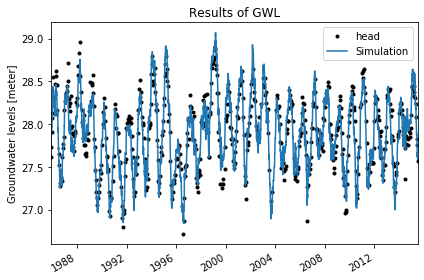

In [10]:
ml.plot()

There are many ways to further visualise the results of the time series model. The `plots` submodule contains all the options. One of these is the method `plots.results` which provides a plot with more information. See the figure below.

''

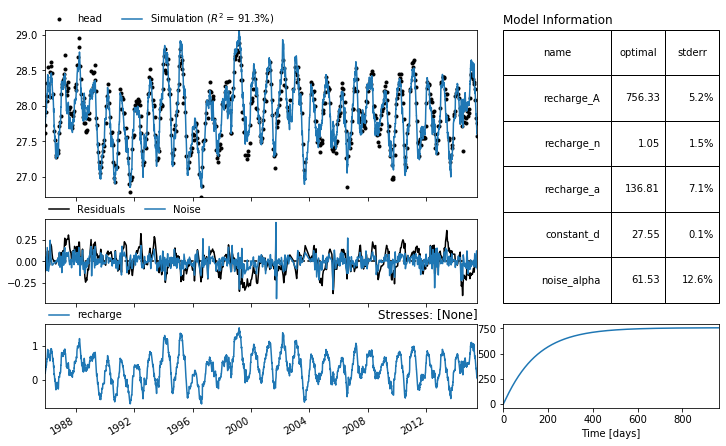

In [11]:
ml.plots.results(figsize=(10, 6))
;

#### Exercise 9 <a name="ex9"></a>
Plot the results of the model with only observations after the 1st of January 2000. What differences do you notice in the results? Use your answer to [exercise 8](#ex8) for this question.

<a href="#ans9">Answer Exercise 9</a>

#### Exercise 10 <a name="ex10"></a>
The folder `data\nb1` contains the files `head_ex10.csv`, `evap_ex10.csv` and `evap_ex10.csv`. Create a time series model using this data. Solve the model and plot the results.  

<a href="#ans10">Answer Exercise 10</a>


## Answers

#### <a href="#ex1">Answer exercise 1</a> <a name="ans1"></a>

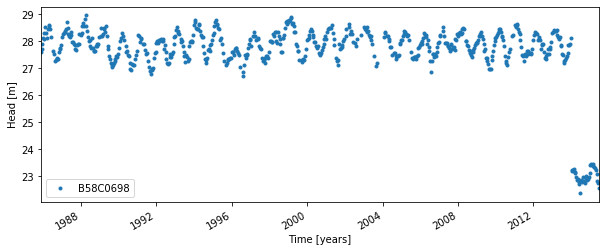

In [12]:
fig, ax = plt.subplots(figsize=(10, 4))
gwdata_raw.plot(style='.', ax=ax, label='B58C0698')
ax.set_ylabel('Head [m]')
ax.set_xlabel('Time [years]')
ax.legend()

#### <a href="#ex2">Answer exercise 2</a> <a name="ans2"></a>

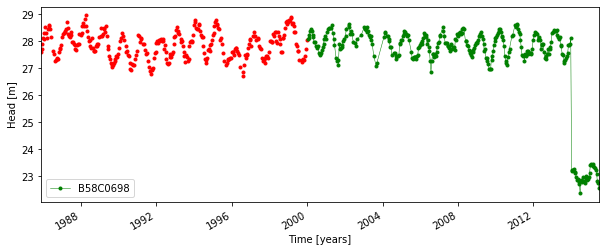

In [13]:
fig, ax = plt.subplots(figsize=(10, 4))

# make subselection of data before 2000
gwdata_before2000 = gwdata_raw.loc[:'2000-1-1']
gwdata_after2000 = gwdata_raw.loc['2000-1-1':]

gwdata_before2000.plot(ax=ax, color='red', style='.')
gwdata_after2000.plot(ax=ax, color='green', linestyle='-',
                      linewidth=0.5, marker='.')

ax.set_ylabel('Head [m]')
ax.set_xlabel('Time [years]')
ax.legend([ax.lines[1]], ['B58C0698'])

#### <a href="#ex3">Answer exercise 3</a> <a name="ans3"></a>

In [14]:
gwdata = gwdata_raw.copy()
gwdata.loc['2014-1-1':] = gwdata.loc['2014-1-1':] + 5

#### <a href="#ex4">Answer exercise 4</a> <a name="ans4"></a>

In [15]:
precip_m = precip_mm/1000
evap_m = evap_mm/1000

#### <a href="#ex5">Answer exercise 5</a> <a name="ans5"></a>

''

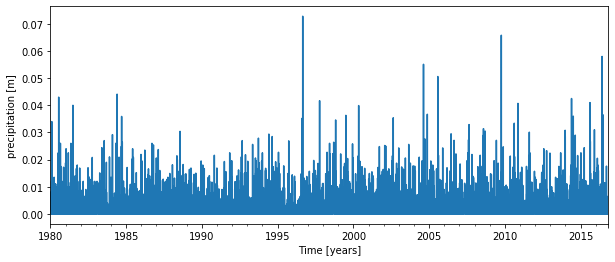

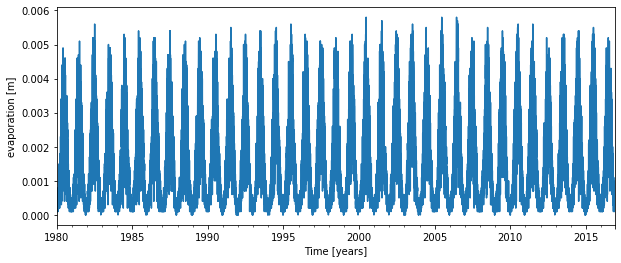

In [16]:
# visualise the observed groundwater levels
fig, ax = plt.subplots(figsize=(10, 4))
precip_m.plot(style='-', ax=ax)
ax.set_ylabel('precipitation [m]')
ax.set_xlabel('Time [years]')

fig, ax = plt.subplots(figsize=(10, 4))
evap_m.plot(style='-', ax=ax)
ax.set_ylabel('evaporation [m]')
ax.set_xlabel('Time [years]')
;

#### <a href="#ex6">Answer exercise 6</a> <a name="ans6"></a>

The data type of the recharge series is: <class 'pandas.core.series.Series'>


''

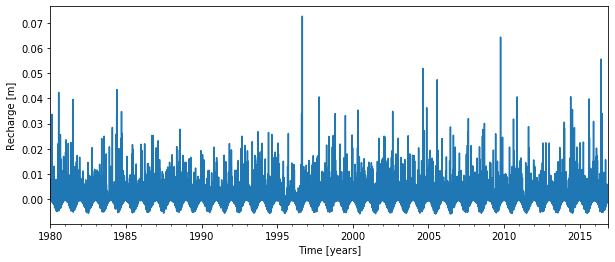

In [17]:
# Calculate the recharge to the groundwater
recharge = precip_m - evap_m
print('The data type of the recharge series is: %s' % type(recharge))

# Plot the time series of the precipitation and evaporation
fig, ax = plt.subplots(figsize=(10, 4))
recharge.plot(style='-', ax=ax)
ax.set_ylabel('Recharge [m]')
ax.set_xlabel('Time [years]')
;

#### <a href="#ex7">Answer exercise 7</a> <a name="ans7"></a>

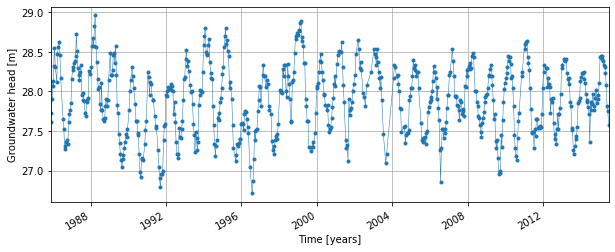

In [18]:
model_dic = ml.to_dict()
oseries = model_dic['oseries']['series']

# Plot the time series of the groundwater
fig, ax = plt.subplots(figsize=(10, 4))
oseries.plot(marker='.', linewidth=0.5, ax=ax)
ax.set_ylabel('Groundwater head [m]')
ax.set_xlabel('Time [years]')
ax.grid()

#### <a href="#ex8">Answer exercise 8</a> <a name="ans8"></a>

In [19]:
gwdata_after2000 = gwdata.loc['2000-1-1':]
ml2 = ps.Model(gwdata_after2000, name="GWL")
ts2 = ps.StressModel(recharge, ps.Gamma, name='recharge', settings="evap")
ml2.add_stressmodel(ts2)
ml2.solve()

INFO: Cannot determine frequency of series head
INFO: Inferred frequency from time series None: freq=D 


Model Results GWL                   Fit Statistics
nfev     28                     EVP          89.42
nobs     330                    R2            0.89
noise    True                   RMSE          0.12
tmin     2000-01-14 00:00:00    AIC           8.39
tmax     2015-06-28 00:00:00    BIC          27.39
freq     D                      ___               
warmup   3650 days 00:00:00     ___               
solver   LeastSquares           ___               

Parameters (5 were optimized)
                optimal   stderr     initial  vary
recharge_A   790.683875   ±8.87%  215.674528  True
recharge_n     1.045398   ±2.25%    1.000000  True
recharge_a   152.990636  ±11.64%   10.000000  True
constant_d    27.532796   ±0.14%   27.918576  True
noise_alpha   51.262088  ±16.52%   14.000000  True

Parameter correlations |rho| > 0.5
recharge_A recharge_a  0.89
           constant_d -0.90
recharge_n recharge_a -0.71
recharge_a constant_d -0.79


#### <a href="#ex9">Answer exercise 9</a> <a name="ans9"></a>

The most important difference between the models are the parameter values and standard errors. They are shown in the table on the right. Off course the period of the plot is also different.

''

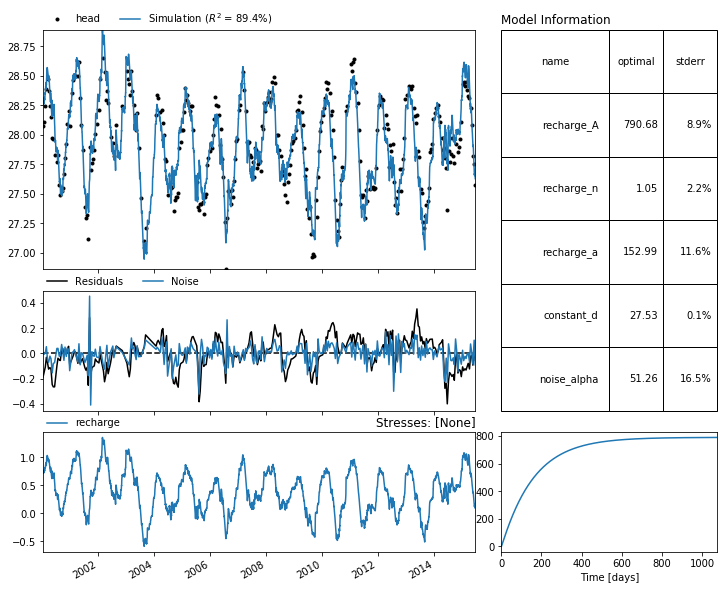

In [20]:
ml2.plots.results()
;

#### <a href="#ex9">Answer exercise 10</a> <a name="ans10"></a>

INFO: Cannot determine frequency of series  Head
INFO: Inferred frequency from time series None: freq=D 


The data type of the recharge series is: <class 'pandas.core.series.Series'>
Model Results GWL                   Fit Statistics
nfev     35                     EVP          31.24
nobs     3869                   R2           -0.07
noise    True                   RMSE          0.37
tmin     1995-01-14 00:00:00    AIC           7.50
tmax     2018-01-12 00:00:00    BIC          38.80
freq     D                      ___               
warmup   3650 days 00:00:00     ___               
solver   LeastSquares           ___               

Parameters (5 were optimized)
                optimal   stderr     initial  vary
recharge_A   174.417101   ±7.39%  203.104730  True
recharge_n     1.488642   ±2.00%    1.000000  True
recharge_a    22.573441   ±7.79%   10.000000  True
constant_d    15.630096   ±0.81%   15.975755  True
noise_alpha  425.397155  ±34.02%    1.000000  True

Parameter correlations |rho| > 0.5
recharge_A recharge_a  0.81
recharge_n recharge_a -0.73


''

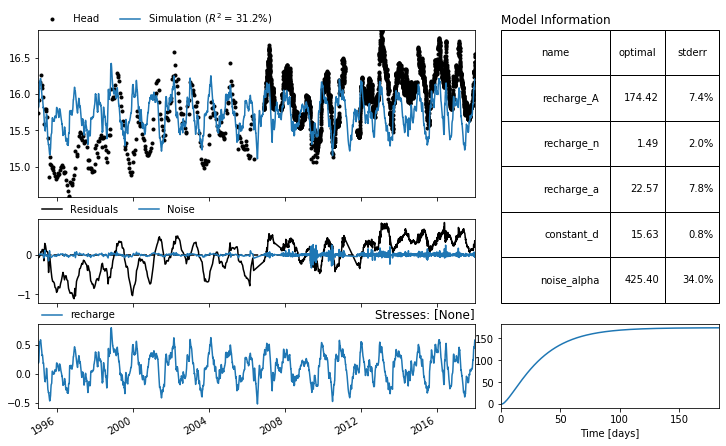

In [21]:
gwdata2 = pd.read_csv('data/nb1/head_ex10.csv', parse_dates=['Date'],
                      index_col='Date', squeeze=True)

precip2 = pd.read_csv('data/nb1/precip_ex10.csv', parse_dates=['Date'],
                      index_col='Date', squeeze=True)

evap2 = pd.read_csv('data/nb1/evap_ex10.csv', parse_dates=['Date'],
                    index_col='Date', squeeze=True)

recharge2 = precip2 - evap2
print('The data type of the recharge series is: %s' % type(recharge))

ml3 = ps.Model(gwdata2, name="GWL")
ts3 = ps.StressModel(recharge2, ps.Gamma, name='recharge', settings="evap")
ml3.add_stressmodel(ts3)
ml3.solve()
ml3.plots.results(figsize=(10, 6))
;

### Origin of the series
* The rainfall data is taken from rainfall station Heibloem in The Netherlands.
* The evaporation data is taken from weather station Maastricht in The Netherlands.
* The head data is well B58C0698, which was obtained from Dino loket